In [1]:
# === GEOPE (STATE PREP) ===
# Units: MHz / ns ; Nc = 15 ; χ = −2 MHz

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

OMEGA_FAC = 2.0 * jnp.pi * 1e-3  # MHz*ns → rad

# ----------------- Operators / Hamiltonian -----------------
def annihilation(Nc: int) -> jnp.ndarray:
    data = jnp.sqrt(jnp.arange(1, Nc, dtype=jnp.float64))
    return jnp.diag(data, 1).astype(jnp.complex128)

def kron(A, B): return jnp.kron(A, B)

def make_ops(Nmax: int):
    Nc = Nmax + 1
    Iq, Ic = jnp.eye(2, dtype=jnp.complex128), jnp.eye(Nc, dtype=jnp.complex128)
    sigx = jnp.array([[0.,1.],[1.,0.]], dtype=jnp.complex128)
    sigy = jnp.array([[0.,-1j],[1j,0.]], dtype=jnp.complex128)
    sigz = jnp.array([[1.,0.],[0.,-1.]], dtype=jnp.complex128)
    a = annihilation(Nc); adag = a.conj().T; n = adag @ a
    X, Y, Z = kron(sigx,Ic), kron(sigy,Ic), kron(sigz,Ic)
    A, Adag, Nop = kron(Iq,a), kron(Iq,adag), kron(Iq,n)
    I = jnp.eye(2*Nc, dtype=jnp.complex128)
    return dict(I=I, X=X, Y=Y, Z=Z, A=A, Adag=Adag, N=Nop)

def build_hamiltonian_ops(ops, wc_MHz, wq_MHz, chi_MHz):
    H0 = (wc_MHz*ops["N"] + 0.5*wq_MHz*ops["Z"] + chi_MHz*(ops["N"]@ops["Z"])).astype(jnp.complex128)
    Glist = [(ops["A"]+ops["Adag"]), (1j*(ops["Adag"]-ops["A"])), ops["X"], ops["Y"]]
    Gstack = jnp.stack(Glist, axis=0).astype(jnp.complex128)
    return H0, Gstack

# ----------------- Fast Hermitian exponential -----------------
def expmH(H, theta):
    evals, evecs = jnp.linalg.eigh(H)
    phases = jnp.exp(-1j * theta * evals)
    return (evecs * phases) @ jnp.conj(evecs).T

# ----------------- Forward + metrics in one pass -----------------
def _hi_indices(Nc, n_hi_start):
    # indices for [|g,n>=n_hi|, |e,n>=n_hi|] in the length-2Nc state vector
    hi = jnp.arange(n_hi_start, Nc, dtype=jnp.int32)
    return jnp.concatenate([hi, hi + Nc], axis=0)

@jax.jit
def propagate_final_and_hi(phi, psi0, H0, Gstack, dt_ns, uscale, hi_idx):
    """One scan to get: final state, mean(high-n), max(high-n)."""
    theta = OMEGA_FAC * dt_ns

    def step(carry, pl):
        psi, mean_acc, max_acc, k = carry
        Hl = H0 + jnp.tensordot(pl * uscale, Gstack, axes=(0,0))
        U  = expmH(Hl, theta)
        psi_next = U @ psi
        p_hi = jnp.sum(jnp.abs(psi_next[hi_idx])**2)  # tail prob
        mean_acc = mean_acc + p_hi
        max_acc  = jnp.maximum(max_acc, p_hi)
        return (psi_next, mean_acc, max_acc, k+1), None

    (psiT, mean_acc, max_acc, L), _ = jax.lax.scan(step, (psi0, 0.0, 0.0, 0), phi)
    mean_hi = mean_acc / jnp.maximum(L, 1)
    return psiT, mean_hi, max_acc

def state_fidelity_from_final(psiT, psitarg):
    amp = jnp.vdot(psitarg, psiT)
    return jnp.real(amp.conj() * amp)

def hilbert_geo_direction(psi: jnp.ndarray, psitarg: jnp.ndarray) -> jnp.ndarray:
    proj = psi * jnp.vdot(psi, psitarg)
    y = psitarg - proj
    nrm = jnp.linalg.norm(y)
    return jnp.where(nrm > 0, y / nrm, jnp.zeros_like(y))

# ----------------- JVP/VJP linear algebra (no full J) -----------------
def complex_to_real(v): return jnp.concatenate([jnp.real(v), jnp.imag(v)], axis=0)

def g_forward(phi, psi0, H0, Gstack, dt_ns, uscale):
    # map controls → final state (real-augmented)
    theta = OMEGA_FAC * dt_ns
    def step(psi, pl):
        Hl = H0 + jnp.tensordot(pl * uscale, Gstack, axes=(0,0))
        U  = expmH(Hl, theta)
        return (U @ psi), None
    psiT, _ = jax.lax.scan(step, psi0, phi)
    return complex_to_real(psiT)

def J_times_vec(phi, vec, psi0, H0, Gstack, dt_ns, uscale):
    _, jvp = jax.jvp(lambda p: g_forward(p, psi0, H0, Gstack, dt_ns, uscale), (phi,), (vec,))
    return jvp

def JT_times_vec(phi, y, psi0, H0, Gstack, dt_ns, uscale):
    _, vjp = jax.vjp(lambda p: g_forward(p, psi0, H0, Gstack, dt_ns, uscale), phi)
    (JT_y,) = vjp(y)
    return JT_y

@jax.jit
def solve_normal_eq_CG(phi, b_real, psi0, H0, Gstack, dt_ns, uscale, lam=1e-6, maxit=60, tol=1e-4):
    rhs = JT_times_vec(phi, b_real, psi0, H0, Gstack, dt_ns, uscale)

    def A_apply(delta):
        Jd = J_times_vec(phi, delta, psi0, H0, Gstack, dt_ns, uscale)
        return JT_times_vec(phi, Jd, psi0, H0, Gstack, dt_ns, uscale) + lam * delta

    def body(val):
        x, r, p, rs_old, k = val
        Ap = A_apply(p)
        alpha = rs_old / (jnp.sum(p * Ap) + 1e-30)
        x_new = x + alpha * p
        r_new = r - alpha * Ap
        rs_new = jnp.sum(r_new * r_new)
        beta = rs_new / (rs_old + 1e-30)
        p_new = r_new + beta * p
        return (x_new, r_new, p_new, rs_new, k+1)

    def cond(val):
        _, _, _, rs_old, k = val
        return jnp.logical_and(jnp.sqrt(rs_old) > tol, k < maxit)

    x0 = jnp.zeros_like(rhs); r0 = rhs - A_apply(x0); p0 = r0; rs0 = jnp.sum(r0 * r0)
    x_final, *_ = jax.lax.while_loop(cond, body, (x0, r0, p0, rs0, 0))
    return x_final

# ----------------- Per-channel clipping -----------------
def clip_controls_per_channel(phi, cav_max=0.6, qb_max=0.9):
    phi = phi.at[:, 0:2].set(jnp.clip(phi[:, 0:2], -cav_max, cav_max))
    phi = phi.at[:, 2:4].set(jnp.clip(phi[:, 2:4], -qb_max,  qb_max))
    return phi

# ----------------- One GEOPE step (fast high-n check) -----------------
def geope_state_step(phi, psi0, psitarg, H0, Gstack, dt_ns, uscale, Nc,
                     eta_max=0.25, ls_iters=4, resid_gain=0.95, tikh=1e-6,
                     cav_clip=0.6, qb_clip=0.9, n_hi_start=12, lam_hi=2.0, tau_hi=0.01):

    hi_idx = _hi_indices(Nc, n_hi_start)

    # baseline: final state + hi-n metrics (one pass)
    psiT0, mean_hi0, max_hi0 = propagate_final_and_hi(phi, psi0, H0, Gstack, dt_ns, uscale, hi_idx)
    f0 = state_fidelity_from_final(psiT0, psitarg)
    f0_pen = f0 - lam_hi * mean_hi0

    # linear solve for delta
    y_c = hilbert_geo_direction(psiT0, psitarg)
    b_real = complex_to_real(y_c)
    delta = solve_normal_eq_CG(phi, b_real, psi0, H0, Gstack, dt_ns, uscale, lam=tikh)

    # line search over a short schedule
    eta = jnp.array(eta_max, dtype=jnp.float64)
    best_eta, best_f_pen, best_r = 0.0, f0_pen, jnp.linalg.norm(b_real)

    for _ in range(ls_iters):
        cand = clip_controls_per_channel(phi + eta * delta, cav_max=cav_clip, qb_max=qb_clip)

        # candidate: final state + hi-n (single pass)
        psiT1, mean_hi1, max_hi1 = propagate_final_and_hi(cand, psi0, H0, Gstack, dt_ns, uscale, hi_idx)
        f1     = state_fidelity_from_final(psiT1, psitarg)
        f1_pen = f1 - lam_hi * mean_hi1

        # linearized residual (cheap JVP/VJP on the final-state map)
        r1 = jnp.linalg.norm(J_times_vec(phi, eta * delta, psi0, H0, Gstack, dt_ns, uscale) - b_real)

        ok_guard = (max_hi1 <= tau_hi)
        accept   = ok_guard & ((f1_pen > best_f_pen) | (r1 < resid_gain * best_r))

        best_eta, best_f_pen, best_r = jax.lax.cond(
            accept,
            lambda _: (float(eta), float(f1_pen), float(r1)),
            lambda _: (best_eta, best_f_pen, best_r),
            None
        )
        eta = eta / 2.0

    phi_new = clip_controls_per_channel(phi + best_eta * delta, cav_max=cav_clip, qb_max=qb_clip) if (best_eta > 0.0) else phi
    return phi_new, (best_eta > 0.0), best_f_pen

def gram_schmidt_escape(phi, scale=0.2, key=jax.random.PRNGKey(0), cav_clip=0.6, qb_clip=0.9):
    rnd = jax.random.normal(key, phi.shape)
    return clip_controls_per_channel(phi + scale * rnd, cav_max=cav_clip, qb_max=qb_clip)

def run_geope_state(phi0, psi0, psitarg, H0, Gstack, dt_ns, uscale, Nc,
                    iters=600, eta_max=0.25, tol=1e-6, resid_gain=0.95, tikh=1e-6,
                    cav_clip=0.6, qb_clip=0.9, n_hi_start=12, lam_hi=2.0, tau_hi=0.01):
    phi = phi0
    history = []
    key = jax.random.PRNGKey(1234)
    for _ in range(iters):
        phi_new, ok, f1 = geope_state_step(phi, psi0, psitarg, H0, Gstack, dt_ns, uscale, Nc,
                                           eta_max=eta_max, ls_iters=4, resid_gain=resid_gain, tikh=tikh,
                                           cav_clip=cav_clip, qb_clip=qb_clip,
                                           n_hi_start=n_hi_start, lam_hi=lam_hi, tau_hi=tau_hi)
        if ok:
            phi = phi_new
        else:
            key, sub = jax.random.split(key)
            phi = gram_schmidt_escape(phi, scale=0.2, key=sub, cav_clip=cav_clip, qb_clip=qb_clip)
        history.append(f1)
        if f1 > 1 - tol:
            break
    return phi, jnp.array(history)

# ----------------- Problem setup (Nc=15) -----------------
Nmax = 14; Nc = Nmax + 1
ops = make_ops(Nmax)
wc_MHz, wq_MHz, chi_MHz = 5.0, 5.0, -2.0
H0, Gstack = build_hamiltonian_ops(ops, wc_MHz, wq_MHz, chi_MHz)

# gentler scales & time grid
uscale_MHz = jnp.array([1.5, 1.5, 7.0, 7.0])
dt_ns, L = 5.0, 160

# states |g,0> → |g,3>
g = jnp.array([1., 0.], dtype=jnp.float64)
c0 = jnp.eye(Nc, dtype=jnp.float64)[0]
psi0 = kron(g.astype(jnp.complex128), c0.astype(jnp.complex128))
n_target = 3
cn = jnp.eye(Nc, dtype=jnp.float64)[n_target]
psitarg = kron(g.astype(jnp.complex128), cn.astype(jnp.complex128))

# warm start (qubit stronger, cavity calmer)
key0 = jax.random.PRNGKey(7)
phi0 = 0.02 * jax.random.normal(key0, (L, 4))
phi0 = phi0.at[:, 0:2].multiply(0.4)  # cavity
phi0 = phi0.at[:, 2:4].multiply(3.0)  # qubit
phi0 = clip_controls_per_channel(phi0, cav_max=0.6, qb_max=0.9)

# optimize
phi_star, history = run_geope_state(
    phi0, psi0, psitarg, H0, Gstack, dt_ns, uscale_MHz, Nc,
    iters=600, eta_max=0.25, tol=1e-6, resid_gain=0.95, tikh=1e-6,
    cav_clip=0.6, qb_clip=0.9, n_hi_start=12, lam_hi=2.0, tau_hi=0.01
)

# ----------------- Diagnostics -----------------
def proj_q(q, Nc):
    Pq = jnp.zeros((2,2), dtype=jnp.complex128).at[q,q].set(1.0)
    return kron(Pq, jnp.eye(Nc, dtype=jnp.complex128))
def proj_n(n, Nc):
    Iq = jnp.eye(2, dtype=jnp.complex128)
    cn = jnp.eye(Nc, dtype=jnp.complex128)[:, n]
    return kron(Iq, jnp.outer(cn, cn.conj()))

psiT, mean_hi, max_hi = propagate_final_and_hi(phi_star, psi0, H0, Gstack, dt_ns, uscale_MHz, _hi_indices(Nc, 12))
Pg = float(jnp.vdot(psiT, proj_q(0, Nc) @ psiT).real)
Pe = float(jnp.vdot(psiT, proj_q(1, Nc) @ psiT).real)
Pn = [float(jnp.vdot(psiT, proj_n(n, Nc) @ psiT).real) for n in range(Nc)]
F_true = float(jnp.vdot(psiT, proj_n(n_target, Nc) @ psiT).real)

print(f"Final state fidelity (|g,{n_target}>): {F_true:.12f}")
print(f"Pg = {Pg:.12f}   Pe = {Pe:.12f}")
for n, p in enumerate(Pn):
    print(f"P(n={n}) = {p:.12e}")
print(f"\nHigh-n (n>=12) mean over traj: {mean_hi:.6e}")
print(f"High-n (n>=12) max  over traj: {max_hi:.6e}")


/opt/anaconda3/envs/jlab-clean/lib/python3.12/site-packages/jax/_src/lax/lax.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Final state fidelity (|g,3>): 0.999802756725
Pg = 0.999887540864   Pe = 0.000112459136
P(n=0) = 2.105490868945e-06
P(n=1) = 3.596046164429e-06
P(n=2) = 1.910746698599e-05
P(n=3) = 9.998027567251e-01
P(n=4) = 1.213067273302e-04
P(n=5) = 3.422572937302e-05
P(n=6) = 8.766431486987e-06
P(n=7) = 3.405754049186e-06
P(n=8) = 3.159763153431e-06
P(n=9) = 1.312279920307e-06
P(n=10) = 9.343257566923e-08
P(n=11) = 4.000968697263e-08
P(n=12) = 7.360269831746e-08
P(n=13) = 3.170478015670e-08
P(n=14) = 1.883589488473e-08

High-n (n>=12) mean over traj: 3.291886e-08
High-n (n>=12) max  over traj: 2.184108e-07


In [ ]:
# ============================
# Geodesic-ness for Fock-state GEOPE (MHz/ns)
# Stores results in `sp_geo` (SimpleNamespace)
# ============================

import jax, jax.numpy as jnp
from types import SimpleNamespace
jax.config.update("jax_enable_x64", True)

# ---- pull required items (no overrides) ----
phi_star   = globals()['phi_star']       # (L, K)
H0         = globals()['H0']             # (N,N)
Gstack     = globals()['Gstack']         # (K,N,N)
dt_ns      = float(globals()['dt_ns'])   # ns
uscale_MHz = globals()['uscale_MHz']     # (K,)
psi0       = globals()['psi0']           # (N,)
psitarg    = globals()['psitarg']        # (N,)
Nc         = int(globals().get('Nc', globals().get('Nmax', 14)+1))
dim        = H0.shape[0]

# Use your OMEGA_FAC if present; default to 2π*1e-3 (MHz·ns → rad)
OMEGA_FAC  = float(globals().get('OMEGA_FAC', 2.0 * jnp.pi * 1e-3))
theta      = OMEGA_FAC * dt_ns
L_steps    = int(phi_star.shape[0])
T_total_ns = L_steps * dt_ns

# ---- helpers ----
def expmH_local(H, th):
    evals, evecs = jnp.linalg.eigh(H)
    phases = jnp.exp(-1j * th * evals)
    return (evecs * phases) @ evecs.conj().T

def householder_lift(psi0, psiT):
    """Unitary V with V psi0 = psiT (up to phase)."""
    def hh(u):
        u = u / (jnp.linalg.norm(u) + 1e-16)
        return jnp.eye(u.size, dtype=psi0.dtype) - 2.0 * jnp.outer(u, u.conj())
    v1 = psi0 - psiT
    H1 = jnp.eye(psi0.size, dtype=psi0.dtype) if jnp.linalg.norm(v1) < 1e-12 else hh(v1)
    psi1 = H1 @ psi0
    v2 = psi1 - psitarg
    H2 = jnp.eye(psi0.size, dtype=psi0.dtype) if jnp.linalg.norm(v2) < 1e-12 else hh(v2)
    V  = H2 @ H1
    phase = jnp.vdot(psitarg, V @ psi0)
    return V * jnp.exp(-1j * jnp.angle(phase))

def fro_inner(A, B): return (jnp.vdot(A.ravel(), B.ravel())).real
def fro_norm(A):     return jnp.sqrt(fro_inner(A, A))

def matrix_log_unitary(W):
    evals, evecs = jnp.linalg.eig(W)
    angles = jnp.angle(evals)                    # principal (-π, π]
    L = evecs @ jnp.diag(1j * angles) @ jnp.linalg.inv(evecs)
    return 0.5 * (L - L.conj().T)                # enforce skew-Hermitian

# ---- rebuild trajectory (U_list, H_list) from phi_star ----
U = jnp.eye(dim, dtype=jnp.complex128)
U_list = []
H_list = []
for pl in phi_star:
    Hl = H0 + jnp.tensordot(pl * uscale_MHz, Gstack, axes=(0, 0))
    U  = expmH_local(Hl, theta) @ U
    U_list.append(U)
    H_list.append(Hl)
U_list = jnp.stack(U_list, axis=0)   # (L, dim, dim)
H_list = jnp.stack(H_list, axis=0)   # (L, dim, dim)
U_T    = U_list[-1]

# ---- target unitary V for state prep (lift to SU(N)) ----
V_target = householder_lift(psi0, psitarg)

# ---- endpoint and instantaneous metrics ----
Gamma  = matrix_log_unitary(U_T.conj().T @ V_target)
L_min  = float(fro_norm(Gamma))                     # dimensionless
L_path = float(jnp.sum(jax.vmap(lambda H: fro_norm(H))(H_list)) * theta)  # Σ θ ||H||

eta_end = float((L_min / (L_path + 1e-16)).real)

cos_vals = []
num_dev, den_geo = 0.0, 0.0
for U_k, H_k in zip(U_list, H_list):
    Omega     = -1j * OMEGA_FAC * H_k
    Omega_geo = (U_k @ Gamma @ U_k.conj().T) / T_total_ns
    nO = float(fro_norm(Omega)); nG = float(fro_norm(Omega_geo)) + 1e-16
    cos_k = float((fro_inner(Omega, Omega_geo) / (nO * nG + 1e-16)).real)
    cos_vals.append(cos_k)
    num_dev += float(fro_norm(Omega - Omega_geo)) * dt_ns
    den_geo += float(nG) * dt_ns

cos_vals = jnp.array(cos_vals)
cos_mean = float(jnp.mean(cos_vals))
cos_min  = float(jnp.min(cos_vals))
cos_std  = float(jnp.std(cos_vals))
delta_geo = float(num_dev / (den_geo + 1e-16))

print("— Geodesic diagnostics (Fock-state GEOPE) —")
print(f"L_min (principal log)  : {L_min:.6f}")
print(f"L_path (Σ θ ||H||)     : {L_path:.6f}   [θ = OMEGA_FAC * dt = {theta:.6e}]")
print(f"η_end = L_min / L_path : {eta_end:.6f}")
print(f"<cos θ>                : {cos_mean:.6f}   (min {cos_min:.6f}, std {cos_std:.6f})")
print(f"δ_geo (rel. dev.)      : {delta_geo:.6f}")

# ---- stash for later plotting/analysis ----
sp_geo = SimpleNamespace(
    U_T=U_T, U_list=U_list, H_list=H_list, V_target=V_target, Gamma=Gamma,
    L_min=L_min, L_path=L_path, eta_end=eta_end,
    cos_mean=cos_mean, cos_min=cos_min, cos_std=cos_std, delta_geo=delta_geo,
    cos_series=cos_vals, theta=theta, dt_ns=dt_ns, OMEGA_FAC=OMEGA_FAC,
    phi_star=phi_star, uscale_MHz=uscale_MHz, H0=H0, Gstack=Gstack
)
print("→ Stored geodesic metrics in `sp_geo` (plus cos_series for plotting).")


— Geodesic diagnostics (Fock-state GEOPE) —
L_min (principal log)  : 9.255548
L_path (Σ θ ||H||)     : 1208.973255   [θ = OMEGA_FAC * dt = 3.141593e-02]
η_end = L_min / L_path : 0.007656
<cos θ>                : -0.059062   (min -0.078438, std 0.011003)
δ_geo (rel. dev.)      : 130.684334
→ Stored geodesic metrics in `sp_geo` (plus cos_series for plotting).


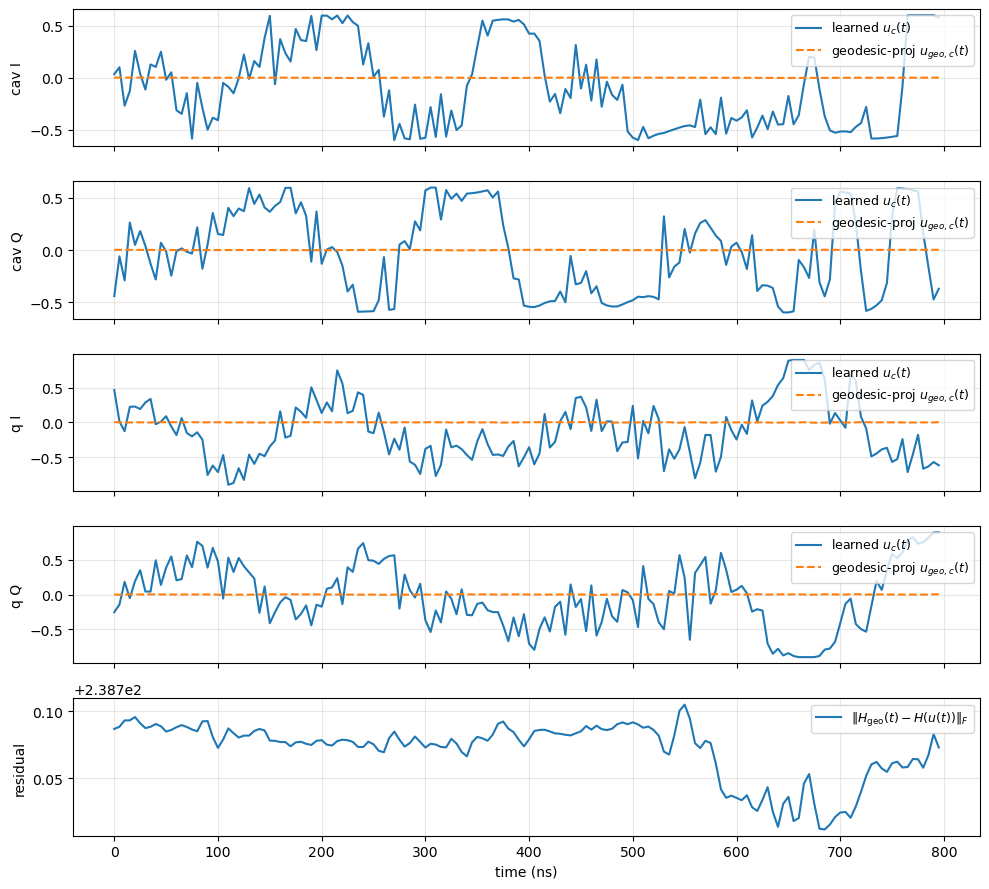

In [ ]:
# ============================
# Compare learned pulses to projected geodesic pulses (state-prep)
# Plots u_geo[t,c] vs phi_star[t,c] and residual(t)
# ============================

import numpy as np
import matplotlib.pyplot as plt

# ---- read from sp_geo ----
if 'sp_geo' not in globals():
    raise RuntimeError("Run the geodesic-ness cell first to create `sp_geo`.")

phi_star   = np.array(sp_geo.phi_star)     # (L, K)
H0         = np.array(sp_geo.H0)
Gstack     = np.array(sp_geo.Gstack)       # (K, N, N)
U_list     = np.array(sp_geo.U_list)       # (L, N, N)
Gamma      = np.array(sp_geo.Gamma)
dt_ns      = float(sp_geo.dt_ns)
OMEGA_FAC  = float(sp_geo.OMEGA_FAC)
uscale_MHz = np.array(sp_geo.uscale_MHz)

L, K = phi_star.shape
dim  = H0.shape[0]

# ---- least-squares projector onto control basis ----
A = np.stack([G.reshape(-1) for G in Gstack], axis=1)   # (dim^2, K)
AH_A    = A.conj().T @ A
AH_A_inv= np.linalg.pinv(AH_A, rcond=1e-12)
A_pinv  = AH_A_inv @ A.conj().T                         # (K, dim^2)

# ---- compute u_geo(t) and residual(t) ----
u_geo = np.zeros((L, K), dtype=np.float64)
resid = np.zeros(L, dtype=np.float64)

for t in range(L):
    U = U_list[t]
    # Ω_geo(t) per unit time; H_geo(t) in MHz via Ω = -i * OMEGA_FAC * H  ⇒  H = (i/OMEGA_FAC) Ω
    Omega_geo = U @ Gamma @ U.conj().T / (L * dt_ns)
    H_geo = (1j / OMEGA_FAC) * Omega_geo

    # Fit controls to match H_geo - H0 ≈ Σ_c (u_c * uscale_c) G_c
    B = (H_geo - H0).reshape(-1)
    s = A_pinv @ B                                  # scaled controls s_c = u_c * uscale_c
    u_hat = s / uscale_MHz[:K]                      # unscale
    u_geo[t, :] = np.real(u_hat)                    # imaginary ~ 0 for Hermitian fit

    # Residual Frobenius norm
    H_fit = H0 + sum((u_hat[c]*uscale_MHz[c])*Gstack[c] for c in range(K))
    resid[t] = np.linalg.norm((H_geo - H_fit).reshape(-1))

# ---- Plot ----
fig, axs = plt.subplots(K+1, 1, figsize=(10, 1.8*(K+1)), sharex=True)
time_ns = np.arange(L) * dt_ns
labels = [r'cav I', r'cav Q', r'q I', r'q Q'][:K]

for c in range(K):
    axs[c].plot(time_ns, phi_star[:, c], label='learned $u_c(t)$')
    axs[c].plot(time_ns, u_geo[:,  c], linestyle='--', label='geodesic-proj $u_{geo,c}(t)$')
    axs[c].set_ylabel(labels[c])
    axs[c].grid(True, alpha=0.3)
    axs[c].legend(loc='upper right', fontsize=9)

axs[K].plot(time_ns, resid, label=r'$\|H_{\rm geo}(t)-H(u(t))\|_F$')
axs[K].set_ylabel('residual')
axs[K].set_xlabel('time (ns)')
axs[K].grid(True, alpha=0.3)
axs[K].legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()


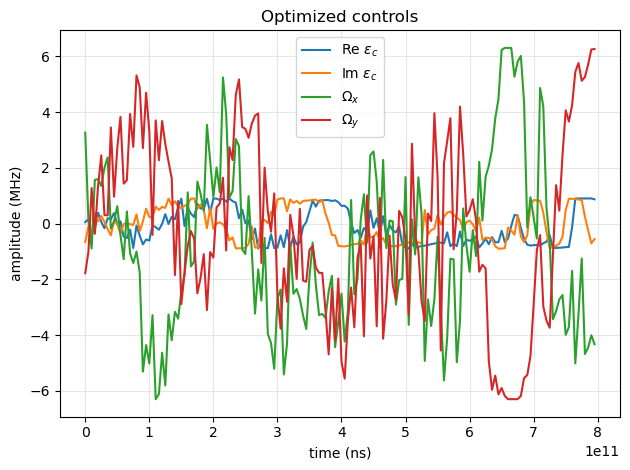

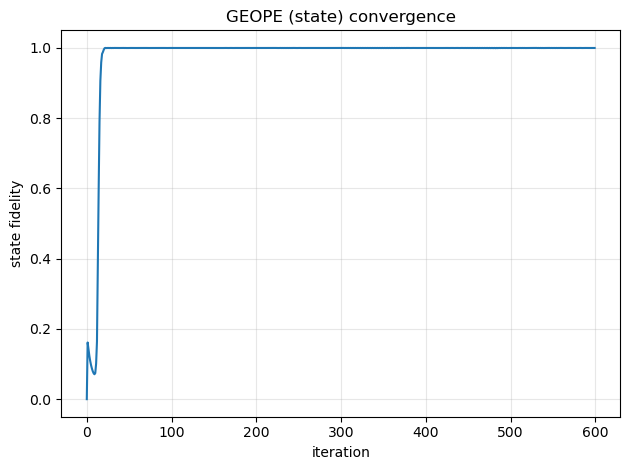

In [ ]:
# --- Plot learned pulses & history ---

import numpy as np
import matplotlib.pyplot as plt

t = np.arange(phi_star.shape[0]) * float(dt_ns)  # seconds
u_phys = np.asarray(phi_star) * np.asarray(uscale_MHz)  # (L,4) rad/s
u_MHz  = u_phys

labels = [r"Re $\epsilon_c$", r"Im $\epsilon_c$", r"$\Omega_x$", r"$\Omega_y$"]

plt.figure()
for k in range(4):
    plt.plot(t*1e9, u_MHz[:,k], label=labels[k])
plt.xlabel("time (ns)")
plt.ylabel("amplitude (MHz)")
plt.title("Optimized controls")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.asarray(history))
plt.xlabel("iteration")
plt.ylabel("state fidelity")
plt.title("GEOPE (state) convergence")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Final Pg = 0.9998875408639314   Final Pe = 0.0001124591360952428
Final P(n=0) = 2.1054908689448033e-06
Final P(n=1) = 3.5960461644292845e-06
Final P(n=2) = 1.9107466985987208e-05
Final P(n=3) = 0.999802756725058
Final P(n=4) = 0.00012130672733023065
Final P(n=5) = 3.42257293730204e-05
Final P(n=6) = 8.766431486987445e-06
Final P(n=7) = 3.4057540491862915e-06
Final P(n=8) = 3.1597631534306844e-06
Final P(n=9) = 1.312279920307172e-06
Final P(n=10) = 9.343257566922932e-08
Final P(n=11) = 4.000968697262667e-08
Final P(n=12) = 7.360269831746445e-08
Final P(n=13) = 3.170478015669592e-08
Final P(n=14) = 1.8835894884732183e-08


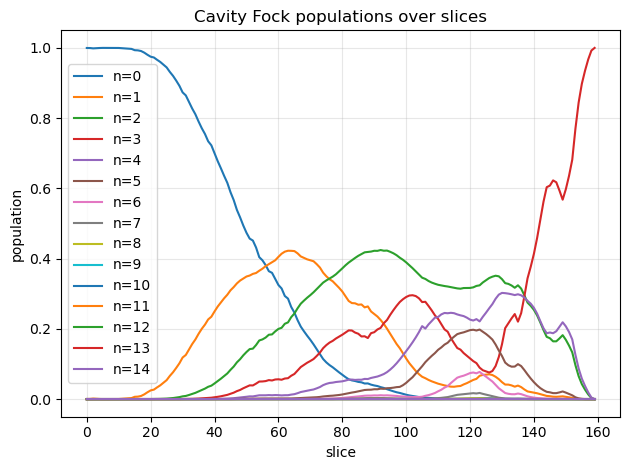

Max P(n=0) = 0.9997893604981063
Max P(n=1) = 0.42243906635207074
Max P(n=2) = 0.4244825668793963
Max P(n=3) = 0.999802756725058
Max P(n=4) = 0.30244498806865255
Max P(n=5) = 0.19815893830157388
Max P(n=6) = 0.07755636330328367
Max P(n=7) = 0.01765247623776281
Max P(n=8) = 0.0025876584555953445
Max P(n=9) = 0.00025303433120463085
Max P(n=10) = 2.4293698427355317e-05
Max P(n=11) = 2.735885967773252e-06
Max P(n=12) = 2.0867004690495455e-07
Max P(n=13) = 3.170478015669592e-08
Max P(n=14) = 1.8835894884732183e-08


In [ ]:
# --- Trajectory populations: ladder climb and final distribution ---

def expmH(H, theta):
    evals, evecs = jnp.linalg.eigh(H)
    phases = jnp.exp(-1j * theta * evals)
    return (evecs * phases) @ jnp.conj(evecs).T

@jax.jit
def forward_trajectory(phi, psi0, H0_MHz, Gstack, dt_ns, uscale_MHz):
    theta = OMEGA_FAC * dt_ns 
    def step(psi, pl):
        Hl_MHz = H0_MHz + jnp.tensordot(pl * uscale_MHz, Gstack, axes=(0, 0))
        U = expmH(Hl_MHz, theta)
        psi_next = U @ psi
        return psi_next, psi_next
    _, traj = jax.lax.scan(step, psi0, phi)  # traj shape: (L, N)
    return traj

traj = forward_trajectory(phi_star, psi0, H0, Gstack, dt_ns, uscale_MHz)  # (L, 2*Nc)
Nc = Nmax + 1

# Same basis ordering as the rest: [|g,0>,...,|g,Nc-1>, |e,0>,...,|e,Nc-1>]
Pg = jnp.sum(jnp.abs(traj[:, :Nc])**2, axis=1)
Pe = jnp.sum(jnp.abs(traj[:, Nc:])**2, axis=1)
Pn = {n: (jnp.abs(traj[:, n])**2 + jnp.abs(traj[:, Nc+n])**2) for n in range(Nc)}

print("Final Pg =", float(Pg[-1]), "  Final Pe =", float(Pe[-1]))
for n in range(Nc):
    print(f"Final P(n={n}) = {float(Pn[n][-1])}")

import matplotlib.pyplot as plt
plt.figure()
for n in range(Nc):
    plt.plot(Pn[n], label=f"n={n}")
plt.xlabel("slice")
plt.ylabel("population")
plt.title("Cavity Fock populations over slices")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
for n in range(Nc):
    print(f"Max P(n={n}) = {float(max(Pn[n]))}")

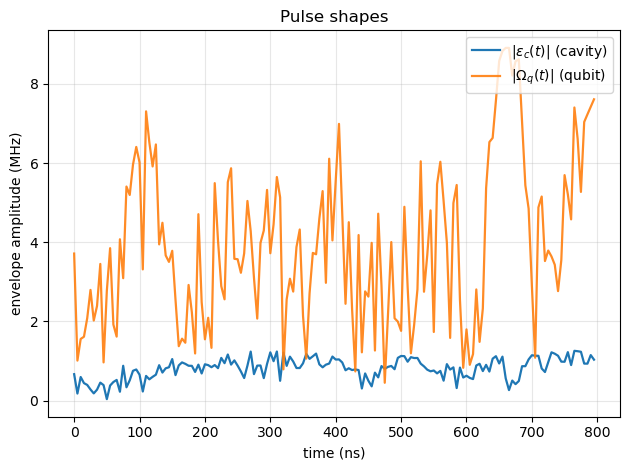

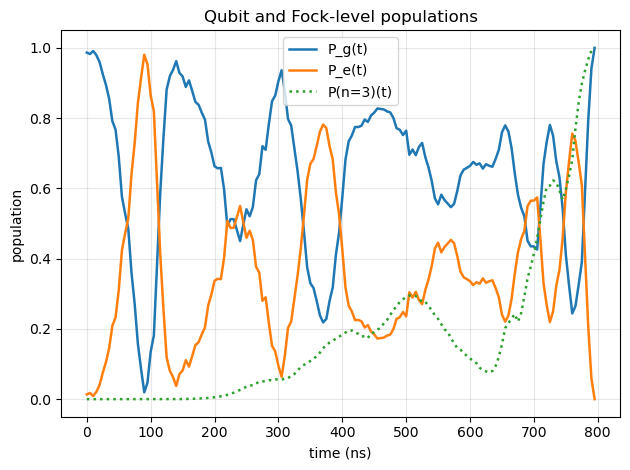

In [ ]:
# === Combined plot: pulse envelopes + qubit population ===
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

Nc = Nmax + 1
L  = phi_star.shape[0]
t  = np.arange(L) * float(dt_ns)  # ns

# Physical controls (MHz)
u_phys = np.asarray(phi_star) * np.asarray(uscale_MHz)
u_MHz  = u_phys

# Complex envelopes
eps_c = u_MHz[:, 0] + 1j * u_MHz[:, 1]   # cavity I/Q
amp_c = np.abs(eps_c)
omega_q = u_MHz[:, 2] + 1j * u_MHz[:, 3] # qubit XY
amp_q = np.abs(omega_q)

# --- Forward trajectory ---
OMEGA_FAC = 2.0 * jnp.pi * 1e-3 

def expmH(H, theta):
    evals, evecs = jnp.linalg.eigh(H)
    phases = jnp.exp(-1j * theta * evals)
    return (evecs * phases) @ jnp.conj(evecs).T

@jax.jit
def forward_trajectory(phi, psi0, H0_MHz, Gstack, dt_ns, uscale_MHz):
    theta = OMEGA_FAC * dt_ns
    def step(psi, pl):
        Hl_MHz = H0_MHz + jnp.tensordot(pl * uscale_MHz, Gstack, axes=(0, 0))
        U = expmH(Hl_MHz, theta)
        psi_next = U @ psi
        return psi_next, psi_next
    _, traj = jax.lax.scan(step, psi0, phi)
    return traj

# Initial state |g,0>
g = jnp.array([1., 0.], dtype=jnp.float64)
c0 = jnp.eye(Nc, dtype=jnp.float64)[0]
psi0 = jnp.kron(g.astype(jnp.complex128), c0.astype(jnp.complex128))

traj = np.asarray(forward_trajectory(phi_star, psi0, H0, Gstack, dt_ns, uscale_MHz))  # (L, 2*Nc)

# Qubit populations
Pg = np.sum(np.abs(traj[:, :Nc])**2, axis=1)
Pe = np.sum(np.abs(traj[:, Nc:])**2, axis=1)

# Optional cavity Fock-level tracking
try:
    n_show = int(n_target)
    Pn = np.abs(traj[:, n_show])**2 + np.abs(traj[:, Nc + n_show])**2
except NameError:
    n_show = None
    Pn = None

# ---------- Plot 1: Pulse envelopes ----------
fig, ax1 = plt.subplots()
ax1.plot(t, amp_c, label=r'$|\epsilon_c(t)|$ (cavity)', linewidth=1.6)
ax1.plot(t, amp_q, label=r'$|\Omega_q(t)|$ (qubit)', linewidth=1.6, alpha=0.9)
ax1.set_xlabel('time (ns)')
ax1.set_ylabel('envelope amplitude (MHz)')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)
plt.title('Pulse shapes')
plt.tight_layout()
plt.show()

# ---------- Plot 2: Qubit and (optional) target Fock populations ----------
plt.figure()
plt.plot(t, Pg, label='P_g(t)', linewidth=1.8)
plt.plot(t, Pe, label='P_e(t)', linewidth=1.8)
if Pn is not None:
    plt.plot(t, Pn, ':', label=fr'P(n={n_show})(t)', linewidth=1.8)
plt.xlabel('time (ns)')
plt.ylabel('population')
plt.title('Qubit and Fock-level populations')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


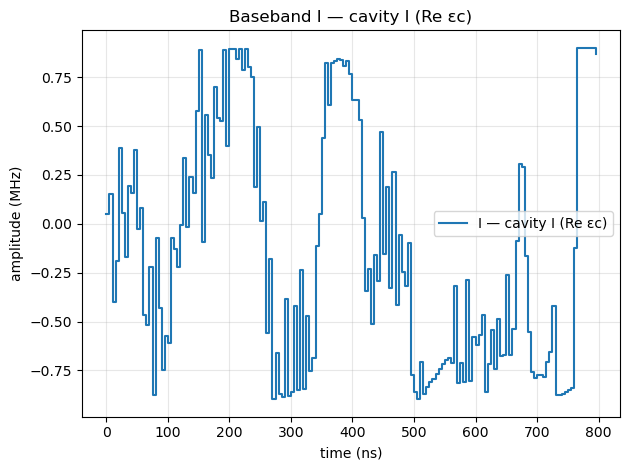

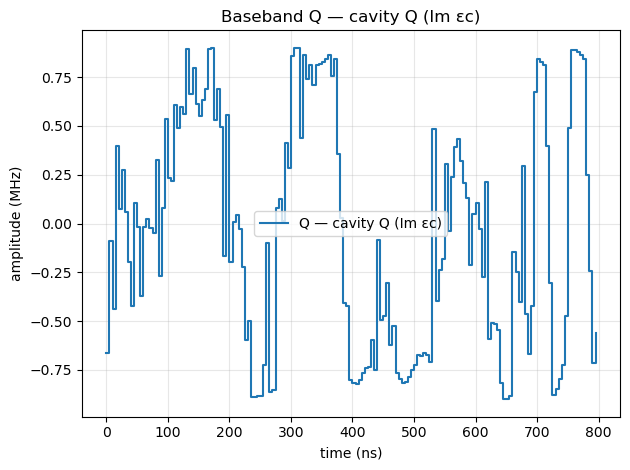

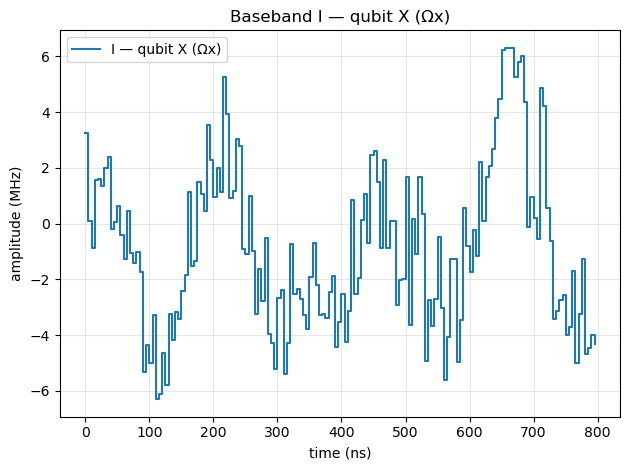

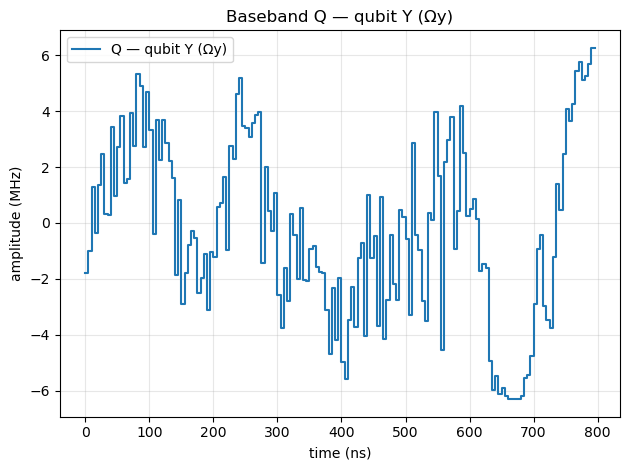

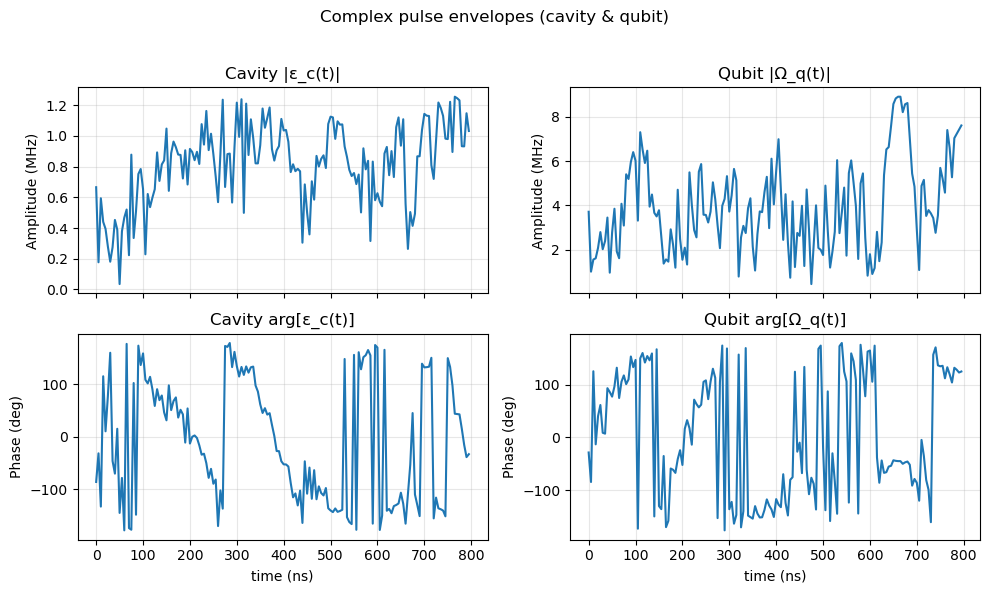

In [ ]:
# === IQ plots for dispersive cavity–qubit controls ===

import numpy as np
import matplotlib.pyplot as plt

# --- Time grid and control scaling ---
L = int(phi_star.shape[0])
t = np.arange(L) * float(dt_ns)  # time in ns

# Convert to physical control amplitudes in MHz
u_MHz = np.asarray(phi_star) * np.asarray(uscale_MHz)  # (L,4) physical amplitudes

# Channel map: [0]=cavity I (Re εc), [1]=cavity Q (Im εc), [2]=qubit X, [3]=qubit Y
labels = ["cavity I (Re εc)", "cavity Q (Im εc)", "qubit X (Ωx)", "qubit Y (Ωy)"]

# --- Build complex baseband envelopes ---
cav_I, cav_Q = u_MHz[:, 0], u_MHz[:, 1]
qb_I,  qb_Q  = u_MHz[:, 2], u_MHz[:, 3]
eps_c = cav_I + 1j * cav_Q     # complex cavity envelope
Om_q  = qb_I  + 1j * qb_Q      # complex qubit envelope

# ------------------------------------------------------------------
# STEP PLOTS: I and Q for each channel (for visualizing waveform segments)
# ------------------------------------------------------------------
for k in range(4):
    plt.figure()
    plt.step(t, u_MHz[:, k], where="post",
             label=("I" if k % 2 == 0 else "Q") + " — " + labels[k])
    plt.xlabel("time (ns)")
    plt.ylabel("amplitude (MHz)")
    plt.title(f"Baseband {'I' if k % 2 == 0 else 'Q'} — {labels[k]}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# AMPLITUDE / PHASE plots for the complex envelopes (cavity & qubit)
# ------------------------------------------------------------------
def amp_phase(z):
    return np.abs(z), np.angle(z, deg=True)

amp_c, ph_c = amp_phase(eps_c)
amp_q, ph_q = amp_phase(Om_q)

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

# Cavity drive
axs[0, 0].plot(t, amp_c)
axs[0, 0].set_title("Cavity |ε_c(t)|")
axs[0, 0].set_ylabel("Amplitude (MHz)")
axs[0, 0].grid(alpha=0.3)

axs[1, 0].plot(t, ph_c)
axs[1, 0].set_title("Cavity arg[ε_c(t)]")
axs[1, 0].set_ylabel("Phase (deg)")
axs[1, 0].set_xlabel("time (ns)")
axs[1, 0].grid(alpha=0.3)

# Qubit drive
axs[0, 1].plot(t, amp_q)
axs[0, 1].set_title("Qubit |Ω_q(t)|")
axs[0, 1].set_ylabel("Amplitude (MHz)")
axs[0, 1].grid(alpha=0.3)

axs[1, 1].plot(t, ph_q)
axs[1, 1].set_title("Qubit arg[Ω_q(t)]")
axs[1, 1].set_ylabel("Phase (deg)")
axs[1, 1].set_xlabel("time (ns)")
axs[1, 1].grid(alpha=0.3)

fig.suptitle("Complex pulse envelopes (cavity & qubit)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
